In [1]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from scipy import stats

%matplotlib inline  

### Versiones de las bibliotecas a utilizar

Seaborn: 0.9.0  
Pandas: 0.23.0  
Numpy: 1.14.3  
MatPlotLib: 2.2.2  
FBProphet: 0.4  
SciPy: 1.1.0  
Python: 3.6.8  


## Metodología
Para realizar esta proyección, utilizaremos la biblioteca Prophet, desarrollada por facebook la que nos permite trabajar con series de tiempo, estacionalidades, tendencias y dias especiales (feriados). 
Para comenzar, debemos manipular el archivo csv para que este tenga un formato adecuado para el uso de la biblioteca y una correcta proyección

In [2]:
df = pd.read_csv('Consumo Gas Región Magallanes.csv', encoding='Windows-1252', delimiter=";")
df.head()

,Consumo,Dia,Mes,Año,DiaSemana,Feriado
0,716,20,10,1995,Viernes,0
1,605,21,10,1995,Sábado,1
2,555,22,10,1995,Domingo,1
3,680,23,10,1995,Lunes,0
4,713,24,10,1995,Martes,0


Convertimos la fecha a formato 'datetime' para trabajar

In [3]:

df['Fecha']=  pd.to_datetime(df.Año.astype(str)+df.Mes.astype(str)+df.Dia.astype(str), format="%Y%m%d")
df.head()

,Consumo,Dia,Mes,Año,DiaSemana,Feriado,Fecha
0,716,20,10,1995,Viernes,0,1995-10-20
1,605,21,10,1995,Sábado,1,1995-10-21
2,555,22,10,1995,Domingo,1,1995-10-22
3,680,23,10,1995,Lunes,0,1995-10-23
4,713,24,10,1995,Martes,0,1995-10-24


Hacemos una revisión inicial a los datos

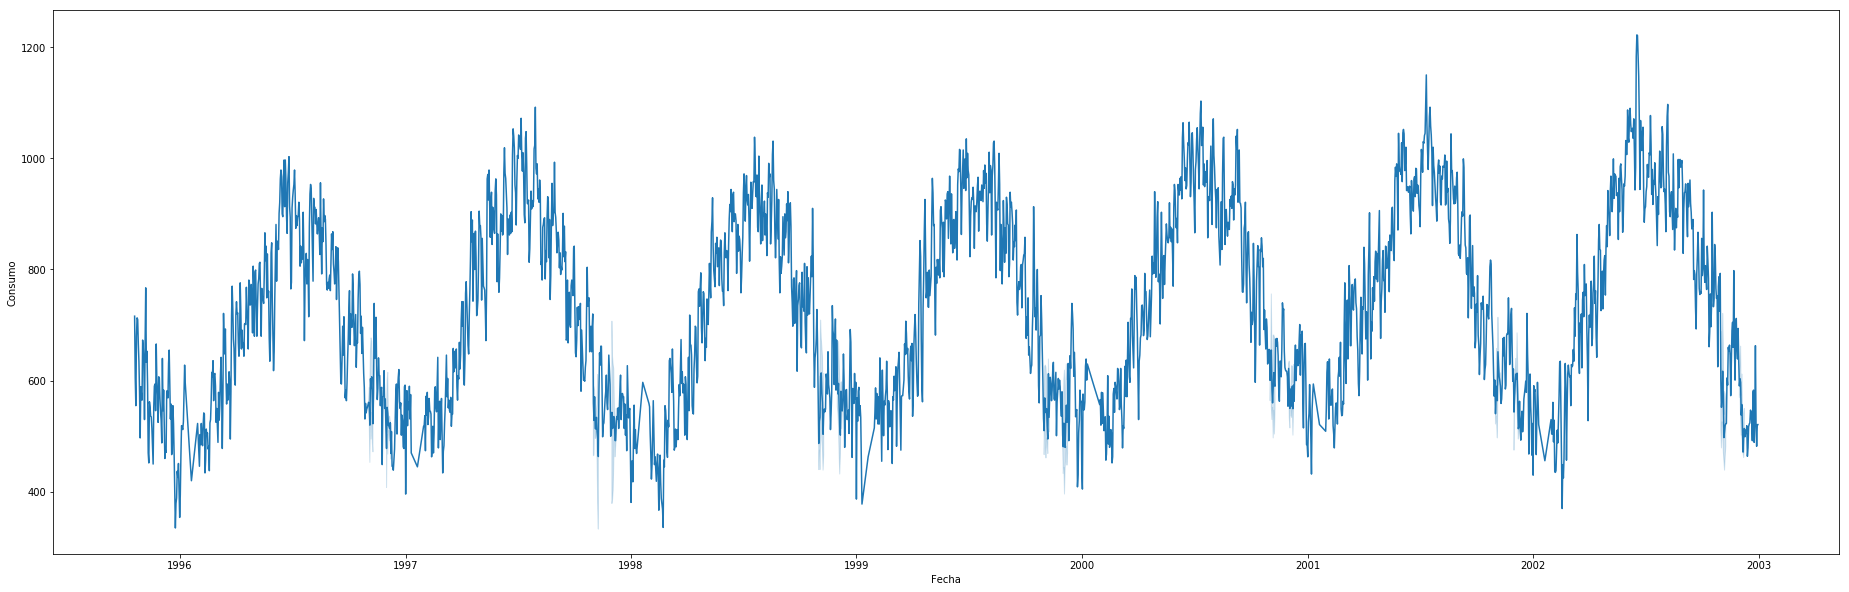

In [4]:
plt.subplots(figsize=(32, 10))
sns.lineplot(x='Fecha', y='Consumo', data=df)

In [5]:
df.groupby(lambda x: df['Fecha'][x].year).mean()['Consumo']


1995    555.150685
1996    687.377049
1997    718.427397
1998    700.079452
1999    724.263014
2000    755.284153
2001    759.547945
2002    768.068493
Name: Consumo, dtype: float64

Notamos la presencia de "outliers", estudiamos eliminar para no generar proyecciones falsas en base a estos datos. Eliminamos todos aquellos que están fuera del 95% de la distribución normal

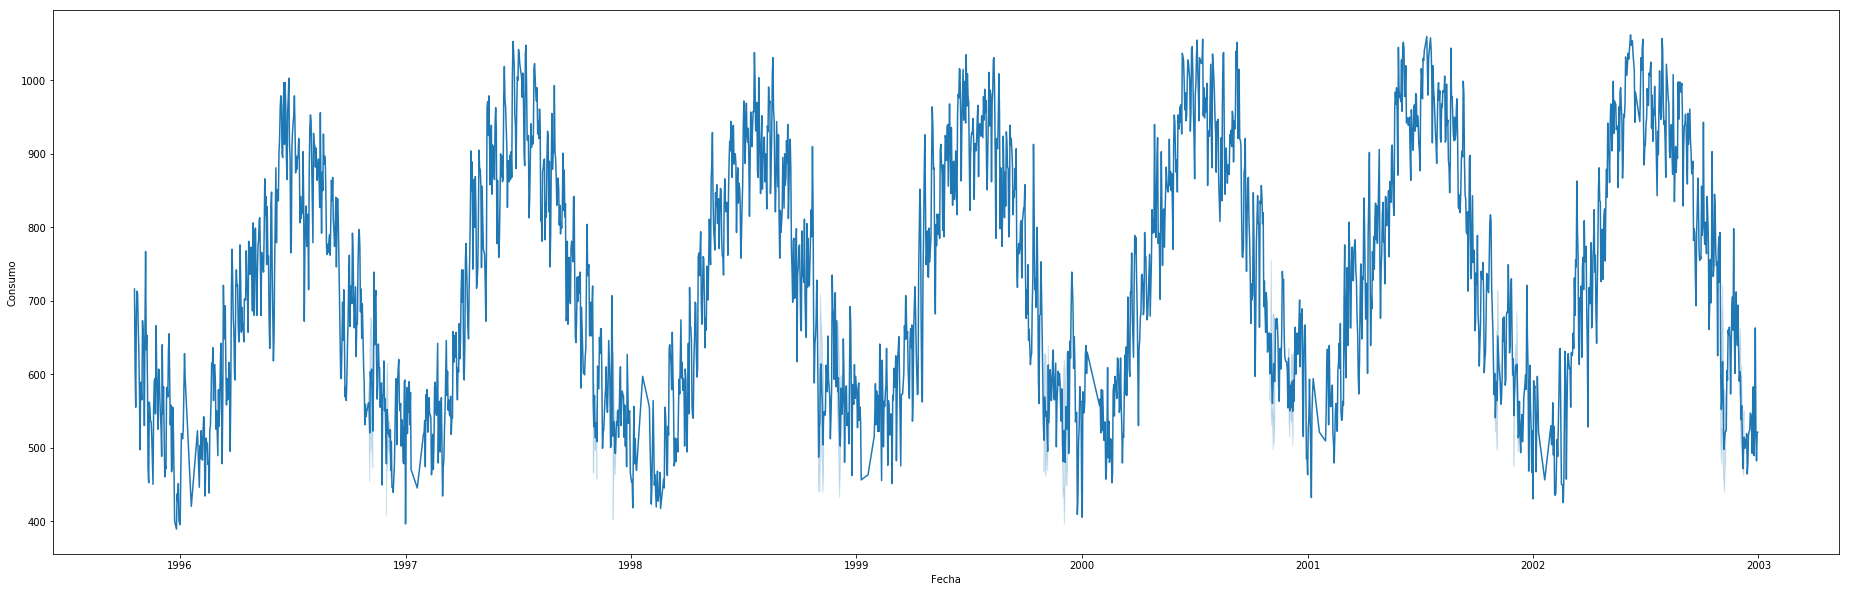

In [6]:


df_norm = df[np.abs(stats.zscore(a=df['Consumo']))<1.96]

plt.subplots(figsize=(32, 10))


sns.lineplot(x='Fecha', y='Consumo', data=df_norm)

In [7]:
df_norm.groupby(lambda x: df['Fecha'][x].year).mean()['Consumo']



1995    560.732394
1996    688.290411
1997    720.286908
1998    705.596100
1999    726.146006
2000    750.831025
2001    755.728532
2002    755.188571
Name: Consumo, dtype: float64

Si bien eliminar los outliers nos da un dataset mas uniforme para trabajar, afecta de forma directa a las observaciones del año 1995 y 2002, disminuyendo el crecimiento sostenido que ha tenido el consumo de gas, por lo que utilizamos finalmente la base original, sin eliminar outliers

Creamos un calendario de feriados (excluyendo los domingos, ya que la biblioteca prophet los considera dentro de la estacionalidad dentro del día de la semana), a partir de los feriados que vienen en la base, más una base externa con los feriados a proyectar (2013)

In [8]:
feriadospre2013 = df[np.logical_and(df['Feriado']==1,df['DiaSemana']!='Domingo')][['Feriado','Fecha']]
feriados2013 = pd.read_excel('feriados2013.xlsx')
feriados2013['Feriado']='1'
feriados2013_f= feriados2013[feriados2013['DiaSem']!=7][['Feriado','Fecha']]
feriados = feriadospre2013.append(feriados2013_f).reset_index()
feriados.drop(columns='index',inplace=True)
feriados.rename(columns={'Feriado':'holiday', 'Fecha':'ds'},inplace=True)
feriados['holiday']='Feriado'

In [9]:
#prophtdf = df_norm.rename(columns={'Fecha': 'ds','Consumo': 'y'})
prophtdf = df.rename(columns={'Fecha': 'ds',
                        'Consumo': 'y'})

## Proyecciones

Para realizar las proyecciones y elegir la mejor, si bien prophet nos entrega varias métricas, esta vez elegiremos en base al rsme (https://www.statisticshowto.datasciencecentral.com/rmse/ para mayor información)

Para la primera proyección utilizaremos el método "aditivo" de estacionalidad, esto es, considerar que las estacionalidades "suman" consumo de gas y no que la estacionalidad sea un factor (multiplicativo)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


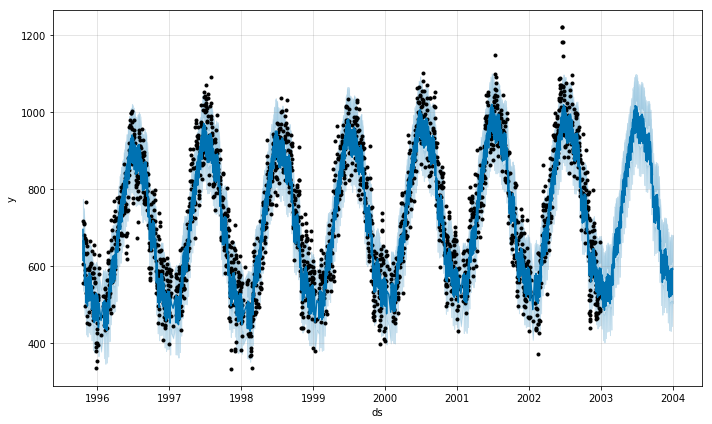

In [10]:
m = Prophet(seasonality_mode='additive')
m.fit(prophtdf)

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)


fig1 = m.plot(forecast)

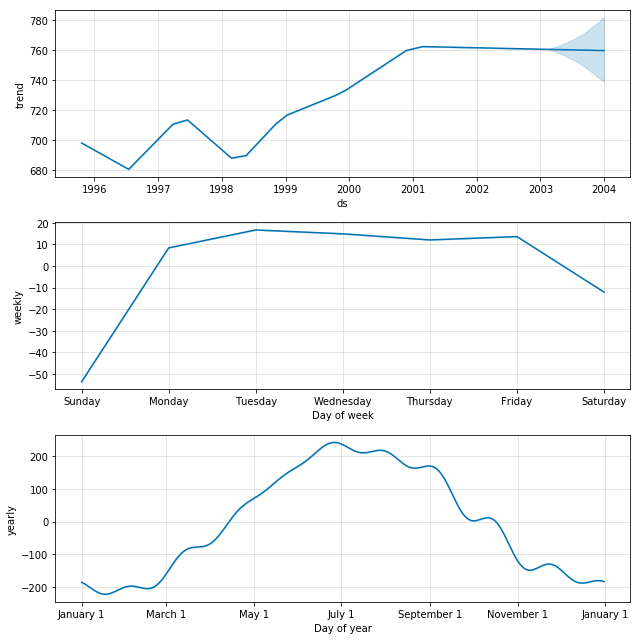

In [11]:
m.plot_components(forecast);


Aprovechamos la misma bliblioteca prophet para hacer validación cruzada, obteniendo finalmente un puntaje de 77,92 rmse

In [12]:
df_cv = cross_validation(m,  horizon = '365 days')

df_p = performance_metrics(df_cv, rolling_window=1)
df_p.head()

INFO:fbprophet:Making 7 forecasts with cutoffs between 1999-01-01 00:00:00 and 2001-12-31 00:00:00
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,horizon,mse,rmse,mae,mape,coverage
2554,365 days,6071.726082,77.921281,62.511122,0.091105,0.706458


In [13]:
df_p['rmse'].mean()

77.92128131379322

#### Mismo modelo, esta vez utilizando el supuesto de estacionalidad multiplicativa

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


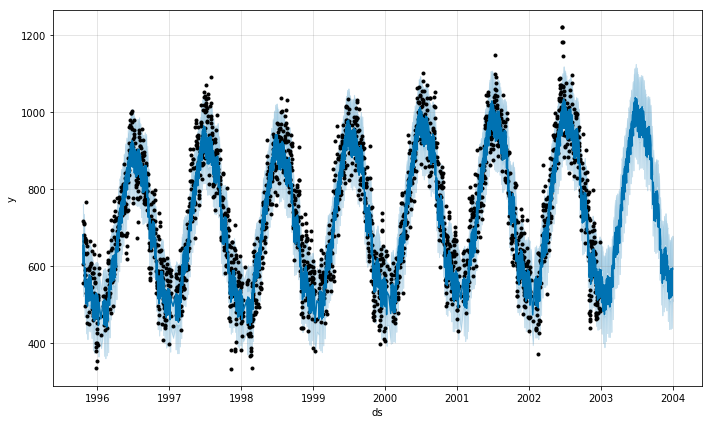

In [14]:
m_multiplicative = Prophet(seasonality_mode='multiplicative')
m_multiplicative.fit(prophtdf)
future_m = m_multiplicative.make_future_dataframe(periods=365)
forecast_m = m_multiplicative.predict(future_m)
fig = m_multiplicative.plot(forecast_m)

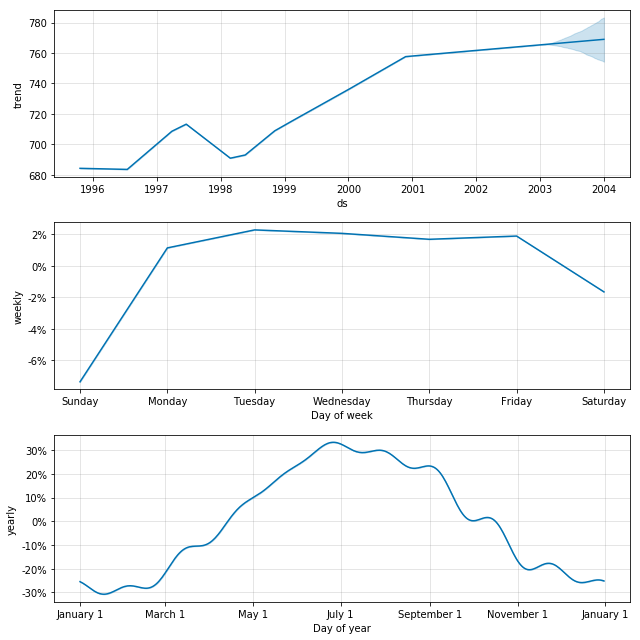

In [15]:
m_multiplicative.plot_components(forecast_m);



In [16]:
df_cv_m = cross_validation(m_multiplicative,  horizon = '365 days')

df_p_m = performance_metrics(df_cv_m, rolling_window=1)
df_p_m.head()

INFO:fbprophet:Making 7 forecasts with cutoffs between 1999-01-01 00:00:00 and 2001-12-31 00:00:00
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,horizon,mse,rmse,mae,mape,coverage
2554,365 days,6181.975754,78.625541,62.966347,0.089695,0.692368


In [17]:
df_p_m['rmse'].mean()

78.6255413562191

El supuesto aditivo nos da un mejor rmse, por lo que utilizaremos este para el siguiente paso:

# Feriados

La biblioteca Prophet nos permite modelar en base a calendarios y regresores especiales, en este caso, consideraremos los feriados para incluir al modelo

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


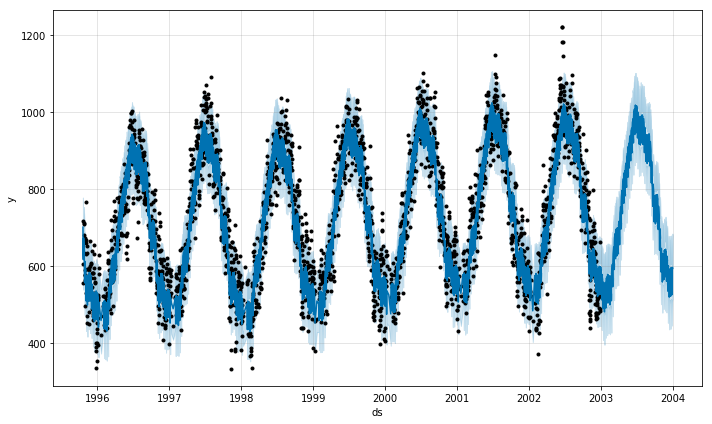

In [18]:
m_holiday = Prophet(holidays=feriados)
m_holiday.fit(prophtdf)

future_holiday = m_holiday.make_future_dataframe(periods=365)
forecast_holiday = m_holiday.predict(future_holiday)


fig1 = m_holiday.plot(forecast_holiday)

In [19]:
df_cv_holiday = cross_validation(m_holiday,  horizon = '365 days')

df_p_holiday = performance_metrics(df_cv_holiday, rolling_window=1)
df_p_holiday.head()

INFO:fbprophet:Making 7 forecasts with cutoffs between 1999-01-01 00:00:00 and 2001-12-31 00:00:00
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,horizon,mse,rmse,mae,mape,coverage
2554,365 days,6068.693174,77.901818,62.479033,0.090779,0.700196


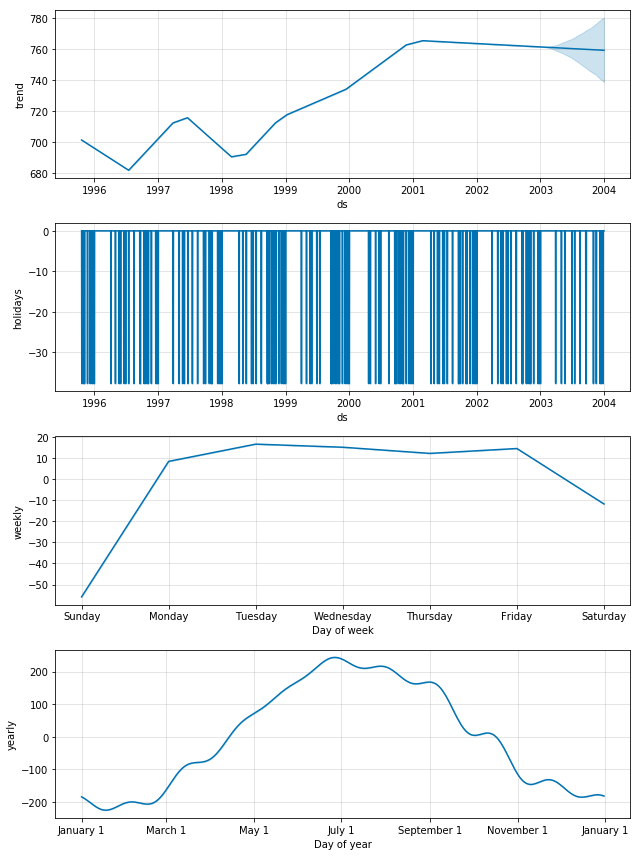

In [20]:
m_holiday.plot_components(forecast_holiday);



Esta version es la que contiene el mejor rmse, por lo que es la que utilizaremos para nuestro forecast final que guardamos a un archivo csv

In [21]:
forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(365).to_csv('ForecastConsumo.csv', encoding='Windows-1252',)